# Sparse graph based networks - some experiments for network type 1

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt

import graph_utils as graph_utils
import graph_neural_networks as graph_nn
import data_preparation_utils as data_prep
from iterative_updaters import VanillaGradientDescent, MomentumGradientDescent, NesterovMomentumGradientDescent, RMSPropGradientDescent, AdamGradientDescent
import training_and_evaluation as train_eval
import graph_nn_experiments as experiments

C:\Users\Lukasz\AppData\Local\conda\conda\envs\aind\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [32]:
m = np.array([[1.2,2.3,3.4],[5.0,-1.2,-0.9],[9.0,-0.8,0.75]])
m

array([[ 1.2 ,  2.3 ,  3.4 ],
       [ 5.  , -1.2 , -0.9 ],
       [ 9.  , -0.8 ,  0.75]])

In [39]:
m[:,[1,0,2]]

array([[ 2.3 ,  1.2 ,  3.4 ],
       [-1.2 ,  5.  , -0.9 ],
       [-0.8 ,  9.  ,  0.75]])

Experiment with the above functions and an artificial adjacency matrix:

In [38]:
artificial_adj_matrix = np.array([[1,1,0,0],[1,1,1,0],[0,1,1,1],[0,0,1,1]])
print(artificial_adj_matrix)

[[1 1 0 0]
 [1 1 1 0]
 [0 1 1 1]
 [0 0 1 1]]


In [44]:
artificial_edges = graph_nn.extract_undirected_edges(artificial_adj_matrix)

In [47]:
artificial_edges_matrix, artificial_edges_bias = graph_nn.get_transfer_matrix_plus_bias_vector(artificial_edges, False)

In [48]:
sess =  tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
m = sess.run(artificial_edges_matrix)
v = sess.run(artificial_edges_bias)
sess.close()
print(m)
print(v)

[[-0.2865445  -0.         -0.        ]
 [-0.07975662  0.19541402  0.        ]
 [ 0.          1.3505175  -0.22902587]
 [-0.         -0.         -0.6132961 ]]
[0. 0. 0.]


In [57]:
artificial_edges_matrix_shared, artificial_edges_bias_shared = graph_nn.get_shared_transfer_matrix_plus_bias_vector(artificial_edges)

In [58]:
sess =  tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
m = sess.run(artificial_edges_matrix_shared)
v = sess.run(artificial_edges_bias_shared)
sess.close()
print(m)
print(v)

[[ 0.48270476  0.          0.        ]
 [-0.11085757  0.48270476  0.        ]
 [ 0.         -0.11085757  0.48270476]
 [-0.         -0.         -0.11085757]]
[0. 0. 0.]


In [50]:
artificial_edges_matrix_transposed, artificial_edges_bias_transposed = graph_nn.get_transfer_matrix_plus_bias_vector(artificial_edges, True)

In [51]:
sess =  tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
m = sess.run(artificial_edges_matrix_transposed)
v = sess.run(artificial_edges_bias_transposed)
sess.close()
print(m)
print(v)

[[-1.530434    0.03792418  0.         -0.        ]
 [-0.         -1.3752512   0.13057522 -0.        ]
 [-0.          0.         -0.7753116  -0.65162235]]
[0. 0. 0. 0.]


Load adjacency matrix for crossings in Ochota:

In [2]:
ochota_adj_matrix = np.genfromtxt("macierz_sasiedztwa.txt")

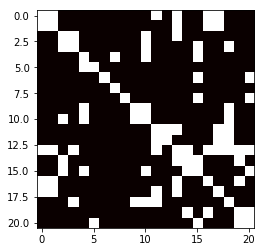

In [3]:
plt.imshow(ochota_adj_matrix, cmap='hot', interpolation='nearest')
plt.show()

Now construct a neural network that uses several layers of transfer matrices. 
Try it out using some random parameters and input:

In [24]:
# also testing the possibility to have more than a single channel in input
number_of_test_channels = 5

inp = tf.placeholder(dtype=tf.float32,shape=[None,21])
inp_mul = tf.reshape(tf.tile(inp,[1,number_of_test_channels]),[-1,21,number_of_test_channels])
nn = graph_nn.transfer_matrix_neural_net(inp_mul, 3, 2, tf.nn.tanh, ochota_adj_matrix, verbose=True)
print(nn.shape)

(21, 48, 5, 2)
(?, 48, 2)
(48, 21, 2, 2)
(?, 21, 2)
(21, 48, 2, 2)
(?, 48, 2)
(?, 96)
(?, 1)


In [25]:
random_input = np.random.normal(loc=0.0,scale=1.0,size=[1,21])

In [26]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
for i in range(1):
    transfered = sess.run(nn, feed_dict={inp: random_input})
    print(transfered)
sess.close()

[[0.9453324]]


It works!

Now try the version with variable channel count:

In [33]:
nn = graph_nn.transfer_matrix_neural_net_var_channels(inp_mul, 3, [2,3,1], tf.nn.tanh, ochota_adj_matrix, verbose=True)
print(nn.shape)

(21, 48, 5, 2)
(?, 48, 2)
(48, 21, 2, 3)
(?, 21, 3)
(21, 48, 3, 1)
(?, 48, 1)
(?, 48)
(?, 1)


In [34]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)
for i in range(1):
    transfered = sess.run(nn, feed_dict={inp: random_input})
    print(transfered)
sess.close()

[[0.12282659]]


Seems to work again

**Now try type 1 architecture on 100k traffic lights dataset:**

Load the data:

In [9]:
traffic_lights_data = pd.read_csv("100k.csv", header=None)
traffic_lights_data.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,81,14,58,108,83,60,82,61,64,94,...,28,87,73,69,25,7,77,95,5,49082
1,81,92,16,44,95,64,110,98,95,105,...,42,5,40,105,118,48,40,62,45,51223
2,75,20,66,104,20,65,80,97,2,81,...,119,115,118,64,68,46,45,43,18,51461
3,30,42,65,108,67,81,85,32,83,48,...,107,79,44,90,6,25,46,102,62,45119
4,117,20,52,40,25,36,87,78,99,70,...,92,21,34,102,37,46,11,9,66,50660


Normalize:

In [10]:
X, y, X_scaler, y_scaler = data_prep.scale_standard_traffic_light_data(traffic_lights_data)

C:\Users\Lukasz\AppData\Local\conda\conda\envs\aind\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [75]:
X.head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.35,-0.766667,-0.033333,0.800000,0.383333,0.000000,0.366667,0.016667,0.066667,0.566667,...,-0.550000,-0.533333,0.450000,0.216667,0.150000,-0.583333,-0.883333,0.283333,0.583333,-0.916667
1,0.35,0.533333,-0.733333,-0.266667,0.583333,0.066667,0.833333,0.633333,0.583333,0.750000,...,0.983333,-0.300000,-0.916667,-0.333333,0.750000,0.966667,-0.200000,-0.333333,0.033333,-0.250000
2,0.25,-0.666667,0.100000,0.733333,-0.666667,0.083333,0.333333,0.616667,-0.966667,0.350000,...,0.050000,0.983333,0.916667,0.966667,0.066667,0.133333,-0.233333,-0.250000,-0.283333,-0.700000
3,-0.50,-0.300000,0.083333,0.800000,0.116667,0.350000,0.416667,-0.466667,0.383333,-0.200000,...,-0.650000,0.783333,0.316667,-0.266667,0.500000,-0.900000,-0.583333,-0.233333,0.700000,0.033333
4,0.95,-0.666667,-0.133333,-0.333333,-0.583333,-0.400000,0.450000,0.300000,0.650000,0.166667,...,-0.483333,0.533333,-0.650000,-0.433333,0.700000,-0.383333,-0.233333,-0.816667,-0.850000,0.100000


In [11]:
X_scaler.inverse_transform(X).head()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,81.0,14.0,58.0,108.0,83.0,60.0,82.0,61.0,64.0,94.0,...,27.0,28.0,87.0,73.0,69.0,25.0,7.0,77.0,95.0,5.0
1,81.0,92.0,16.0,44.0,95.0,64.0,110.0,98.0,95.0,105.0,...,119.0,42.0,5.0,40.0,105.0,118.0,48.0,40.0,62.0,45.0
2,75.0,20.0,66.0,104.0,20.0,65.0,80.0,97.0,2.0,81.0,...,63.0,119.0,115.0,118.0,64.0,68.0,46.0,45.0,43.0,18.0
3,30.0,42.0,65.0,108.0,67.0,81.0,85.0,32.0,83.0,48.0,...,21.0,107.0,79.0,44.0,90.0,6.0,25.0,46.0,102.0,62.0
4,117.0,20.0,52.0,40.0,25.0,36.0,87.0,78.0,99.0,70.0,...,31.0,92.0,21.0,34.0,102.0,37.0,46.0,11.0,9.0,66.0


In [79]:
y_scaler.inverse_transform(y)

array([49082., 51223., 51461., ..., 52152., 46318., 45916.])

Normalization seems to work ok.

Train test split:

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=831191)

Now construct the neural net and define the loss:

In [9]:
# also testing the possibility to have more than a single channel in input (turned off for the moment)
#number_of_test_channels = 2

nn_input = tf.placeholder(dtype=tf.float32, shape=[None, 21])
targets = tf.placeholder(dtype=tf.float32, shape=[None, 1])
nn_output = graph_nn.transfer_matrix_neural_net(nn_input, 3, 4, tf.nn.tanh, ochota_adj_matrix, verbose=True, share_weights_in_transfer_matrix=False, share_biases_in_transfer_matrix=False)

# also testing the possibility to have more than a single channel in input (turned off for the moment)
#nn_input_mul = tf.tile(tf.expand_dims(nn_input,-1),[1,1,number_of_test_channels])
#nn_output = graph_nn.transfer_matrix_neural_net(nn_input_mul, 3, 4, tf.nn.tanh, ochota_adj_matrix, verbose=True, share_weights_in_transfer_matrix=True, share_biases_in_transfer_matrix=True)

(21, 48, 1, 4)
(?, 48, 4)
(48, 21, 4, 4)
(?, 21, 4)
(21, 48, 4, 4)
(?, 48, 4)
(?, 192)


__NOTE__: transfer_matrix_neural_net(traffic_signal_settings, 3, 4, tf.nn.tanh, ochota_adj_matrix) seems to work ok (+ Adam using 0.01 learning rate)

Now define the optimizer:

In [18]:
optimizer = tf.train.AdamOptimizer(0.005) #0.0035

Define batch iterator: 

In [15]:
batch_iterator = data_prep.BatchIterator(X_train, y_train, 997)

Now, train for several epochs:

In [16]:
test_and_batch_losses = train_eval.train_model(nn_output, nn_input, targets, optimizer, 100000, batch_iterator, X_test, y_test, "trained_networks/test_model.ckpt", 1000, verbose=True)

Test loss: 1.065527, batch loss: 1.034799, model saved under trained_networks/test_model.ckpt
Test loss: 0.359556, batch loss: 0.349825, model saved under trained_networks/test_model.ckpt
Test loss: 0.263340, batch loss: 0.266800, model saved under trained_networks/test_model.ckpt
Test loss: 0.224152, batch loss: 0.211581, model saved under trained_networks/test_model.ckpt
Test loss: 0.205417, batch loss: 0.202294, model saved under trained_networks/test_model.ckpt
Test loss: 0.188925, batch loss: 0.188196, model saved under trained_networks/test_model.ckpt
Test loss: 0.182010, batch loss: 0.183637, model saved under trained_networks/test_model.ckpt
Test loss: 0.175232, batch loss: 0.172581, model saved under trained_networks/test_model.ckpt
Test loss: 0.167460, batch loss: 0.173869, model saved under trained_networks/test_model.ckpt
Test loss: 0.165570, batch loss: 0.156800, model saved under trained_networks/test_model.ckpt
Test loss: 0.158971, batch loss: 0.151875, model saved under

Test loss: 0.093596, batch loss: 0.083137, model saved under trained_networks/test_model.ckpt
Test loss: 0.095734, batch loss: 0.088141, model saved under trained_networks/test_model.ckpt
Test loss: 0.093557, batch loss: 0.097133, model saved under trained_networks/test_model.ckpt
Test loss: 0.101190, batch loss: 0.099426, model saved under trained_networks/test_model.ckpt
Test loss: 0.091758, batch loss: 0.086438, model saved under trained_networks/test_model.ckpt
Test loss: 0.095180, batch loss: 0.094800, model saved under trained_networks/test_model.ckpt
Test loss: 0.092668, batch loss: 0.086958, model saved under trained_networks/test_model.ckpt
Test loss: 0.106465, batch loss: 0.104106, model saved under trained_networks/test_model.ckpt
Test loss: 0.093023, batch loss: 0.086677, model saved under trained_networks/test_model.ckpt
Test loss: 0.115540, batch loss: 0.157675, model saved under trained_networks/test_model.ckpt
Test loss: 0.093226, batch loss: 0.099021, model saved under

Check relative accuracy on test set:

In [10]:
model_avg_error, actual_vs_predicted = train_eval.evaluate_model_on_a_dataset("trained_networks/test_model.ckpt", nn_output,nn_input, X_test, y_test, y_scaler)
print(model_avg_error)

INFO:tensorflow:Restoring parameters from trained_networks/test_model.ckpt
0.015926799864290454


Text(0.5,1,'Actual vs. predicted')

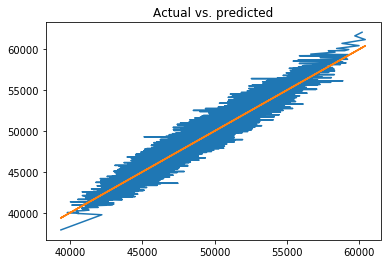

In [11]:
y_test_sorted = [x[0] for x in actual_vs_predicted]
y_test_pred_sorted = [x[1] for x in actual_vs_predicted]
plt.plot(y_test_pred_sorted, y_test_sorted)
plt.plot(y_test_pred_sorted, y_test_pred_sorted)
plt.title("Actual vs. predicted")

Evaluation seems to work ok.

Restore from checkpoint:

In [12]:
# close session (if open)
try:
    sess.close()
except:
    pass

# open new session
sess =  tf.Session()

saver = tf.train.Saver()
saver.restore(sess, "trained_networks/test_model.ckpt")

INFO:tensorflow:Restoring parameters from trained_networks/test_model.ckpt


Generate a gradient descent trajectory:

In [11]:
updater = MomentumGradientDescent()

trajectory = train_eval.generate_gradient_descent_trajectory(sess, nn_output, nn_input, X_scaler, y_scaler, updater, 1000, 10, verbose=True)

Prediction 46894.921875, rounded: 46888.683594
Prediction 41557.691406, rounded: 41605.753906
Prediction 39231.582031, rounded: 39225.292969
Prediction 38048.019531, rounded: 38086.511719
Prediction 37587.140625, rounded: 37589.535156
Prediction 37150.460938, rounded: 37164.949219
Prediction 36869.613281, rounded: 36868.000000
Prediction 36680.125000, rounded: 36686.429688
Prediction 36566.257812, rounded: 36573.644531
Prediction 36494.878906, rounded: 36493.582031
Prediction 36441.726562, rounded: 36444.585938
Prediction 36399.996094, rounded: 36402.472656
Prediction 36364.925781, rounded: 36363.199219
Prediction 36333.625000, rounded: 36335.769531
Prediction 36304.128906, rounded: 36316.269531
Prediction 36272.976562, rounded: 36275.941406
Prediction 36224.941406, rounded: 36230.093750
Prediction 35994.167969, rounded: 35996.300781
Prediction 34520.683594, rounded: 34538.011719
Prediction 34169.554688, rounded: 34170.523438
Prediction 33981.644531, rounded: 33980.585938
Prediction 33

Seems to work fine.

Generate several gradient optimization paths for comparison with simulation:

In [15]:
no_of_trajectories = 1 #set this to a higher number to get multiple trajectories

updater = NesterovMomentumGradientDescent()

trajectories = train_eval.generate_and_join_multiple_gradient_descent_trajectories(sess, no_of_trajectories, nn_output, nn_input, X_scaler, y_scaler, updater, 1000, 100, verbose=True, trajectories_verbose=False)

Generating trajectory 1


In [17]:
predictions_from_trajectories = [x[1] for x in trajectories]
print("Min prediction: %f" % min(predictions_from_trajectories))
print("Mean prediction: %f" % np.mean(predictions_from_trajectories))
print("Median prediction: %f" % np.median(predictions_from_trajectories))

Min prediction: 32656.738281
Mean prediction: 34621.199219
Median prediction: 34669.195312


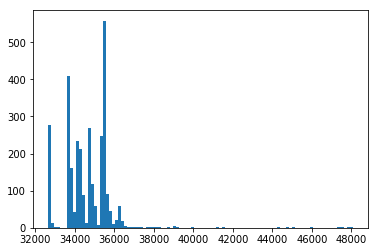

In [18]:
_ = plt.hist(predictions_from_trajectories, bins=100)

### Comparison with simulator outputs 

First test if the microservice works

In [4]:
simulator_microservice_url = "http://3.122.113.135:25041/" #this IP may change

In [5]:
import requests
import json
resp = requests.post(simulator_microservice_url, json={'user':'pgora', 'password':'Ghzf8ftb', 'settings':"[26,31,11,18,60,15,112,34,37,10,21,52,13,114,15,76,117,18,39,20,81]"}, headers={'Content-Type': 'application/json'})
float(json.loads(resp.text)['score'])

51389.0

Now generate a test set based on trajectories and the corresponding simulation results:

In [32]:
# set this equal to the number of threads in the simulator virtual machine
no_of_threads = 8

simulation_test_X, simulation_test_y = train_eval.generate_test_set_from_trajectory_points(trajectories, no_of_threads, simulator_microservice_url, verbose=True)
# simulation test set needs to be scaled before plugging it into a network
simulation_test_X = X_scaler.transform(simulation_test_X)
simulation_test_y = y_scaler.transform(simulation_test_y.reshape(-1,1)).reshape(-1)

Creating queues
Getting locks
Filling the queue
Starting the threads
Processing point: [45, 66, 62, 93, 92, 39, 52, 70, 38, 94, 27, 74, 45, 69, 71, 71, 44, 55, 73, 26, 85]
Processing point: [40, 22, 49, 78, 96, 38, 82, 73, 45, 107, 37, 46, 40, 40, 20, 38, 31, 26, 45, 34, 113]
Processing point: [40, 22, 50, 78, 94, 34, 81, 76, 61, 108, 37, 46, 41, 40, 20, 37, 32, 26, 45, 35, 117]
Processing point: [40, 22, 50, 78, 94, 29, 81, 78, 77, 108, 37, 46, 41, 40, 20, 37, 32, 26, 45, 35, 118]
Processing point: [40, 22, 50, 78, 94, 25, 81, 81, 87, 108, 37, 46, 41, 40, 20, 37, 32, 26, 45, 35, 119]
Processing point: [40, 22, 50, 78, 94, 21, 81, 84, 93, 108, 37, 46, 41, 40, 20, 37, 32, 26, 45, 35, 119]
Processing point: [40, 22, 50, 78, 94, 18, 81, 86, 98, 108, 37, 46, 41, 40, 20, 37, 32, 26, 45, 35, 119]
Processing point: [40, 22, 50, 78, 94, 16, 81, 88, 101, 108, 37, 46, 41, 40, 20, 37, 32, 26, 45, 35, 119]
Processing point: [40, 22, 50, 78, 94, 14, 81, 90, 104, 108, 37, 46, 41, 40, 20, 37, 32, 26,

Evaluate the net on the test set created above:

In [34]:
model_avg_simulation_error, actual_simulation_vs_predicted = train_eval.evaluate_model_on_a_dataset("trained_networks/test_model.ckpt", nn_output,nn_input, simulation_test_X, simulation_test_y, y_scaler)
print(model_avg_simulation_error)

INFO:tensorflow:Restoring parameters from trained_networks/test_model.ckpt
0.020770852733328318


Text(0.5,1,'Actual vs. predicted')

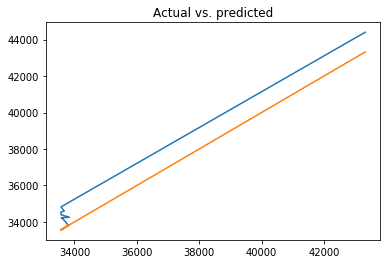

In [36]:
y_simulation_test_sorted = [x[0] for x in actual_simulation_vs_predicted]
y_simulation_test_pred_sorted = [x[1] for x in actual_simulation_vs_predicted]
plt.plot(y_simulation_test_pred_sorted, y_simulation_test_sorted)
plt.plot(y_simulation_test_pred_sorted, y_simulation_test_pred_sorted)
plt.title("Actual vs. predicted")

**NOTE:** Just a quick test - meaningful results obtained obtained in the main experiment run outside this notebook

### Random graph topology experiments

Testing random graph topologies:

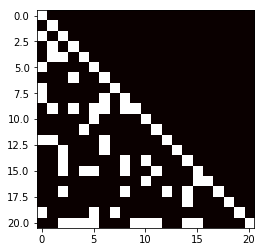

Distance: 80, 80 (should be equal)


In [7]:
random_adj_matrix = graph_utils.generate_random_adjacency_matrix(21, 48)

plt.imshow(random_adj_matrix, cmap="hot")
plt.show()

#random_adj_matrix

print("Distance: %d, %d (should be equal)" % 
      (graph_utils.undirected_symmetric_difference(ochota_adj_matrix, random_adj_matrix),
       graph_utils.undirected_symmetric_difference(random_adj_matrix, ochota_adj_matrix)))

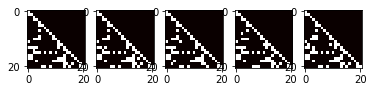

In [8]:
for i in range(5):
    random_adj_matrix = graph_utils.generate_random_adjacency_matrix_with_fixed_symmetric_difference(i, ochota_adj_matrix)
    plt.subplot(151+i)
    plt.imshow(random_adj_matrix, cmap="hot")
plt.show()

Generate many random graph topologies, train for each of them:

Constructing random adjacency matrix with symmetric diff 9
21 21


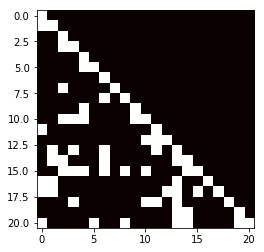

Constructing graph neural net
Training network with symmetric diff 9
Test loss: 1.047199, batch loss: 1.008966, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.402060, batch loss: 0.372220, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.293666, batch loss: 0.306077, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.232332, batch loss: 0.226070, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.219599, batch loss: 0.219199, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.190193, batch loss: 0.172811, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.175762, batch loss: 0.165930, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.169464, batch loss: 0.176569, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.163128, batch loss: 0.165233, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.156918, batch loss

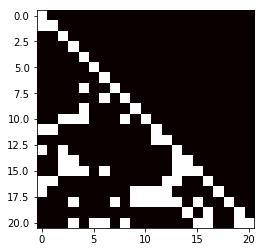

Constructing graph neural net
Training network with symmetric diff 12
Test loss: 1.077768, batch loss: 1.079691, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.365071, batch loss: 0.338486, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.269846, batch loss: 0.296396, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.215017, batch loss: 0.201232, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.223096, batch loss: 0.217597, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.187949, batch loss: 0.185032, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.177786, batch loss: 0.171363, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.173191, batch loss: 0.182442, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.166933, batch loss: 0.161187, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.160932, batch los

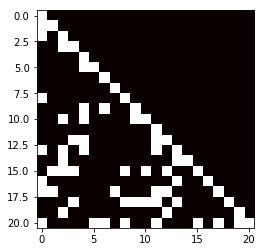

Constructing graph neural net
Training network with symmetric diff 15
Test loss: 1.077955, batch loss: 1.078014, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.465968, batch loss: 0.452226, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.345890, batch loss: 0.344625, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.286405, batch loss: 0.287559, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.258496, batch loss: 0.266453, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.244006, batch loss: 0.232720, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.241621, batch loss: 0.216430, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.224289, batch loss: 0.224364, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.216798, batch loss: 0.228745, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.209041, batch los

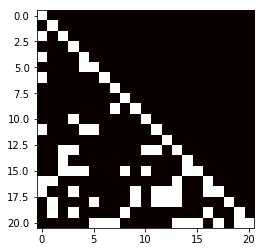

Constructing graph neural net
Training network with symmetric diff 18
Test loss: 1.081496, batch loss: 1.082605, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.466951, batch loss: 0.425778, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.261538, batch loss: 0.262675, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.206368, batch loss: 0.191028, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.200735, batch loss: 0.206990, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.175596, batch loss: 0.176453, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.170974, batch loss: 0.148153, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.162944, batch loss: 0.174535, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.156518, batch loss: 0.153884, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.153312, batch los

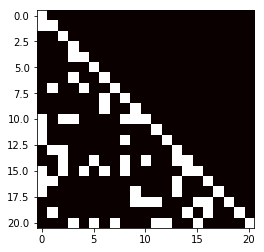

Constructing graph neural net
Training network with symmetric diff 21
Test loss: 1.077446, batch loss: 1.068067, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.372558, batch loss: 0.351598, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.290323, batch loss: 0.333953, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.248953, batch loss: 0.235479, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.237926, batch loss: 0.238871, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.219323, batch loss: 0.219130, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.219527, batch loss: 0.190415, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.197560, batch loss: 0.206142, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.201981, batch loss: 0.214508, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.189311, batch los

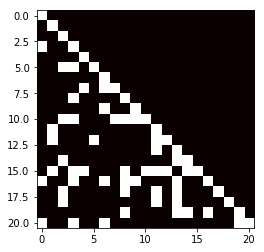

Constructing graph neural net
Training network with symmetric diff 24
Test loss: 1.024014, batch loss: 1.009679, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.512643, batch loss: 0.495941, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.408793, batch loss: 0.406128, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.353240, batch loss: 0.345001, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.329634, batch loss: 0.347115, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.316488, batch loss: 0.320815, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.305758, batch loss: 0.291096, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.298965, batch loss: 0.304578, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.290328, batch loss: 0.290970, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.273095, batch los

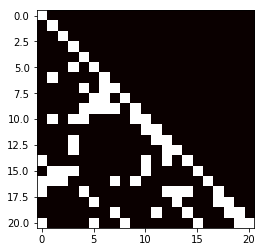

Constructing graph neural net
Training network with symmetric diff 27
Test loss: 1.027546, batch loss: 0.992043, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.541732, batch loss: 0.502618, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.407766, batch loss: 0.397179, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.304542, batch loss: 0.297740, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.253328, batch loss: 0.293839, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.234525, batch loss: 0.221710, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.226301, batch loss: 0.212567, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.211955, batch loss: 0.222076, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.209185, batch loss: 0.219765, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.205176, batch los

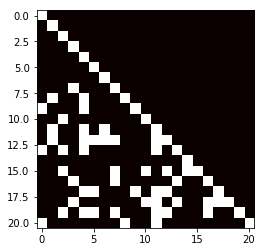

Constructing graph neural net
Training network with symmetric diff 30
Test loss: 1.134186, batch loss: 1.091817, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.567875, batch loss: 0.504339, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.462017, batch loss: 0.479609, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.380105, batch loss: 0.374940, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.279137, batch loss: 0.291783, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.263524, batch loss: 0.247399, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.251668, batch loss: 0.241737, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.242590, batch loss: 0.250889, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.239789, batch loss: 0.232993, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.227202, batch los

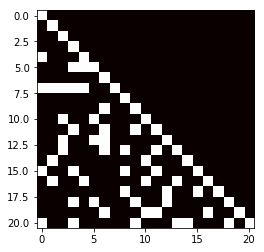

Constructing graph neural net
Training network with symmetric diff 33
Test loss: 1.075522, batch loss: 1.067181, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.441453, batch loss: 0.388755, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.321410, batch loss: 0.324837, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.289839, batch loss: 0.264851, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.266775, batch loss: 0.275126, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.230597, batch loss: 0.243776, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.221397, batch loss: 0.212207, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.217075, batch loss: 0.227172, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.212845, batch loss: 0.212279, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.205689, batch los

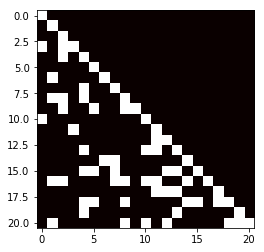

Constructing graph neural net
Training network with symmetric diff 36
Test loss: 1.069873, batch loss: 1.061924, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.506222, batch loss: 0.461574, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.361222, batch loss: 0.367480, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.283576, batch loss: 0.269280, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.262143, batch loss: 0.255208, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.228175, batch loss: 0.219139, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.214251, batch loss: 0.203457, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.201969, batch loss: 0.216584, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.198758, batch loss: 0.190688, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.186244, batch los

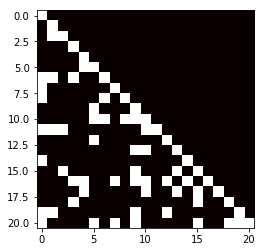

Constructing graph neural net
Training network with symmetric diff 39
Test loss: 1.043940, batch loss: 1.007284, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.812086, batch loss: 0.794245, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.656367, batch loss: 0.663790, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.473329, batch loss: 0.503335, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.427723, batch loss: 0.437674, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.387589, batch loss: 0.367845, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.346807, batch loss: 0.318951, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.330195, batch loss: 0.329714, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.318597, batch loss: 0.322204, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.308961, batch los

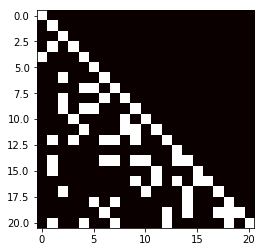

Constructing graph neural net
Training network with symmetric diff 42
Test loss: 1.038535, batch loss: 1.013710, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.523781, batch loss: 0.490158, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.376114, batch loss: 0.384938, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.335848, batch loss: 0.354165, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.287326, batch loss: 0.296993, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.274011, batch loss: 0.264942, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.262162, batch loss: 0.243199, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.247779, batch loss: 0.253951, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.239283, batch loss: 0.238881, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.236988, batch los

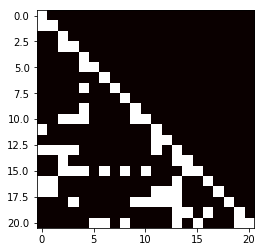

Constructing graph neural net
Training network with symmetric diff 0
Test loss: 1.111355, batch loss: 1.065310, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.400468, batch loss: 0.369743, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.238708, batch loss: 0.255189, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.201918, batch loss: 0.187359, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.194321, batch loss: 0.201241, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.174186, batch loss: 0.167442, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.163958, batch loss: 0.148960, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.160621, batch loss: 0.166460, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.153653, batch loss: 0.158629, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.150173, batch loss

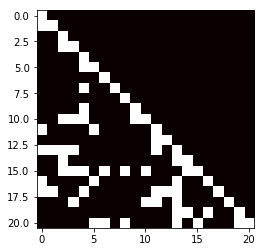

Constructing graph neural net
Training network with symmetric diff 3
Test loss: 1.102020, batch loss: 1.058828, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.358326, batch loss: 0.323712, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.276766, batch loss: 0.298916, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.236348, batch loss: 0.245907, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.219360, batch loss: 0.216784, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.189628, batch loss: 0.184096, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.180992, batch loss: 0.175832, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.171060, batch loss: 0.180768, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.167439, batch loss: 0.168520, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.159328, batch loss

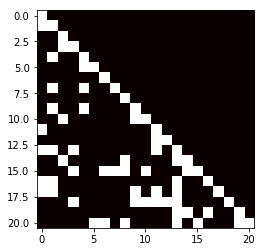

Constructing graph neural net
Training network with symmetric diff 6
Test loss: 1.032613, batch loss: 0.999725, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.363001, batch loss: 0.328753, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.260761, batch loss: 0.257293, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.211962, batch loss: 0.197291, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.214819, batch loss: 0.207408, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.185326, batch loss: 0.170765, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.175532, batch loss: 0.155762, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.168504, batch loss: 0.179153, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.164178, batch loss: 0.165616, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.159621, batch loss

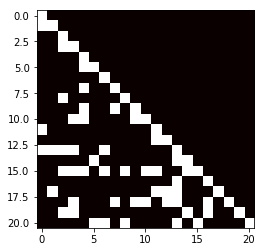

Constructing graph neural net
Training network with symmetric diff 9
Test loss: 1.079251, batch loss: 1.065361, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.385702, batch loss: 0.320051, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.294490, batch loss: 0.308356, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.257877, batch loss: 0.255295, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.246665, batch loss: 0.264779, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.229885, batch loss: 0.220252, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.221822, batch loss: 0.207112, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.211755, batch loss: 0.216502, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.205374, batch loss: 0.208137, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.194122, batch loss

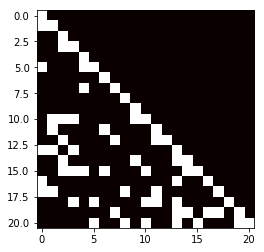

Constructing graph neural net
Training network with symmetric diff 12
Test loss: 1.099211, batch loss: 1.087814, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.393739, batch loss: 0.358768, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.287933, batch loss: 0.305775, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.242012, batch loss: 0.224307, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.236367, batch loss: 0.233048, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.204885, batch loss: 0.195653, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.195022, batch loss: 0.172688, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.184894, batch loss: 0.192279, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.176452, batch loss: 0.176664, model saved under trained_networks/random_model_tmp.ckpt
Test loss: 0.170284, batch los

KeyboardInterrupt: 

In [7]:
symmetric_diffs = [3 * i for i in range(15)]
no_of_samples = 5
symmetric_diffs *= no_of_samples

symmetric_diffs = symmetric_diffs[3:] # just for the moment

file_to_save_results = "random_topologies_3_2.csv"

with open(file_to_save_results,"a") as f:
    for i in symmetric_diffs:
        print("Constructing random adjacency matrix with symmetric diff %d" % i)
        random_adj_matrix = graph_utils.generate_random_adjacency_matrix_with_fixed_symmetric_difference(i, ochota_adj_matrix)
        plt.imshow(random_adj_matrix, cmap="hot")
        plt.show()
        tf.reset_default_graph()
        nn_input = tf.placeholder(dtype=tf.float32, shape=[None, 21])
        targets = tf.placeholder(dtype=tf.float32, shape=[None, 1])
        print("Constructing graph neural net")
        nn_output = graph_nn.transfer_matrix_neural_net(nn_input, 3, 4, tf.nn.tanh, random_adj_matrix, verbose=False, share_weights_in_transfer_matrix=False, share_biases_in_transfer_matrix=False)
        optimizer = tf.train.AdamOptimizer(0.005)
        batch_iterator = data_prep.BatchIterator(X_train, y_train, 997)
        print("Training network with symmetric diff %d" % i)
        test_and_batch_losses = train_eval.train_model(nn_output, nn_input, targets, optimizer, 30000, batch_iterator, X_test, y_test, "trained_networks/random_model_tmp.ckpt", 1000, verbose=True)
        test_loss = test_and_batch_losses[-1][0]
        model_avg_error, actual_vs_predicted = train_eval.evaluate_model_on_a_dataset("trained_networks/random_model_tmp.ckpt", nn_output,nn_input, X_test, y_test, y_scaler)
        f.write("%d,%f,%f\n" % (i, model_avg_error, test_loss))
        f.flush()
        print((i, model_avg_error, test_loss))
    f.close()

**NOTE**: Just a quick test, main results obtained outside this notebook and loaded and presented here

Random graphs experiment results for type 1 graph neural networks:

In [2]:
random_topologies_results = np.genfromtxt("random_topologies_3_2.csv",delimiter=",")

In [3]:
rand_top_data_frame = pd.DataFrame(random_topologies_results, columns=["SymmetricDiff","RelativeError","MeanSquaredError"])
medians = rand_top_data_frame.groupby("SymmetricDiff").median()
lower_five_perc = rand_top_data_frame.groupby("SymmetricDiff").quantile(0.05)
upper_five_perc = rand_top_data_frame.groupby("SymmetricDiff").quantile(0.95)
medians

,RelativeError,MeanSquaredError
SymmetricDiff,,
0.0,0.018080,0.116229
3.0,0.018266,0.118777
6.0,0.018547,0.122112
9.0,0.018764,0.124993
12.0,0.018923,0.127552
15.0,0.019387,0.133410
18.0,0.019646,0.137564
21.0,0.020341,0.146094
24.0,0.020650,0.151769


In [4]:
rand_top_data_frame_ = rand_top_data_frame.copy()
rand_top_data_frame_["Count"] = 1
rand_top_data_frame_ = rand_top_data_frame_[["SymmetricDiff","Count"]]
rand_top_data_frame_.groupby("SymmetricDiff").sum()

,Count
SymmetricDiff,
0.0,157
3.0,156
6.0,156
9.0,156
12.0,156
15.0,156
18.0,156
21.0,156
24.0,156


In [25]:
rel_error_y_err_max = pd.DataFrame()
rel_error_y_err_max["RelativeErrorMax"] = upper_five_perc.loc[:,"RelativeError"] - medians.loc[:,"RelativeError"]
rel_error_y_err_min = pd.DataFrame()
rel_error_y_err_min["RelativeErrorMin"] = medians.loc[:,"RelativeError"] - lower_five_perc.loc[:,"RelativeError"]
rel_error_y_err = pd.concat([rel_error_y_err_min,rel_error_y_err_max], axis=1).transpose().iloc[0:2,:]

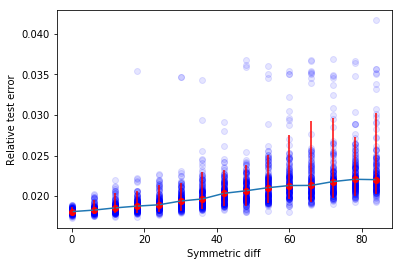

In [30]:
plt.plot(rand_top_data_frame.iloc[:,0] * 2,rand_top_data_frame.iloc[:,1],"bo", alpha=0.1, zorder=-32)
plt.plot(medians.index.values * 2,medians.iloc[:,0], "ro",zorder=-32)
plt.errorbar(medians.index.values * 2,medians.iloc[:,0],yerr=rel_error_y_err.values,ecolor="r", barsabove=True)
plt.xlabel("Symmetric diff")
plt.ylabel("Relative test error")
plt.show()

In [31]:
ms_error_y_err_max = pd.DataFrame()
ms_error_y_err_max["MeanSquaredErrorMax"] = upper_five_perc.loc[:,"MeanSquaredError"] - medians.loc[:,"MeanSquaredError"]
ms_error_y_err_min = pd.DataFrame()
ms_error_y_err_min["MeanSquaredErrorMin"] = medians.loc[:,"MeanSquaredError"] - lower_five_perc.loc[:,"MeanSquaredError"]
ms_error_y_err = pd.concat([ms_error_y_err_min,ms_error_y_err_max], axis=1).transpose().iloc[0:2,:]

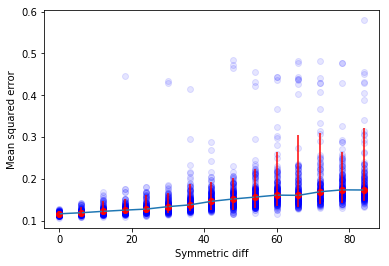

In [32]:
plt.plot(rand_top_data_frame.iloc[:,0] * 2,rand_top_data_frame.iloc[:,2],"bo", alpha=0.1, zorder=-32)
plt.plot(medians.index.values * 2,medians.iloc[:,1], "ro", zorder=-32)
plt.errorbar(medians.index.values * 2,medians.iloc[:,1],yerr=ms_error_y_err.values,ecolor="r", barsabove=True)
plt.xlabel("Symmetric diff")
plt.ylabel("Mean squared error")
plt.show()

### Permuted topologies experiments summary

In [33]:
permuted_topologies_results = np.genfromtxt("permuted_topologies_0.csv",delimiter=",")

In [67]:
perm_top_data_frame = pd.DataFrame(permuted_topologies_results, columns=["NoOfTranspositions","SymmetricDiff","RelativeError","MeanSquaredError"])
medians = perm_top_data_frame.groupby("SymmetricDiff").median()
lower_five_perc = perm_top_data_frame.groupby("SymmetricDiff").quantile(0.05)
upper_five_perc = perm_top_data_frame.groupby("SymmetricDiff").quantile(0.95)
medians

,NoOfTranspositions,RelativeError,MeanSquaredError
SymmetricDiff,,,
0.0,0.0,0.018069,0.116542
4.0,1.0,0.018415,0.120540
6.0,1.0,0.018130,0.117396
8.0,1.0,0.018161,0.117635
10.0,1.0,0.018688,0.124211
12.0,1.0,0.018394,0.120348
14.0,1.0,0.019180,0.131874
16.0,1.0,0.018803,0.126247
18.0,2.0,0.018667,0.124117


In [73]:
perm_top_data_frame_ = perm_top_data_frame.copy()
perm_top_data_frame_["Count"] = 1
perm_top_data_frame_ = perm_top_data_frame_[["SymmetricDiff","Count"]]
perm_top_data_frame_.groupby("SymmetricDiff").sum()

,Count
SymmetricDiff,
0.0,105
4.0,5
6.0,7
8.0,7
10.0,17
12.0,17
14.0,31
16.0,19
18.0,15


In [69]:
rel_error_y_err_max = pd.DataFrame()
rel_error_y_err_max["RelativeErrorMax"] = upper_five_perc.loc[:,"RelativeError"] - medians.loc[:,"RelativeError"]
rel_error_y_err_min = pd.DataFrame()
rel_error_y_err_min["RelativeErrorMin"] = medians.loc[:,"RelativeError"] - lower_five_perc.loc[:,"RelativeError"]
rel_error_y_err = rel_error_y_err_min

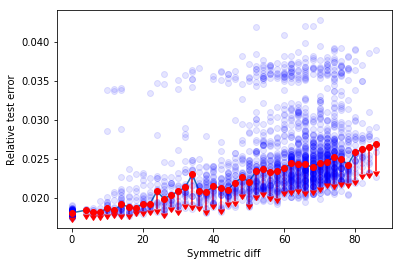

In [70]:
plt.plot(perm_top_data_frame.iloc[:,1],perm_top_data_frame.iloc[:,2],"bo",alpha=0.1)
plt.plot(medians.index.values,medians.iloc[:,1], "ro")
plt.errorbar(medians.index.values,medians.iloc[:,1],yerr=rel_error_y_err.values,lolims=False,uplims=True,ecolor="r", barsabove=True)
plt.xlabel("Symmetric diff") # <-- not divided by two here
plt.ylabel("Relative test error")
plt.show()

In [71]:
ms_error_y_err_max = pd.DataFrame()
ms_error_y_err_max["MeanSquaredErrorMax"] = upper_five_perc.loc[:,"MeanSquaredError"] - medians.loc[:,"MeanSquaredError"]
ms_error_y_err_min = pd.DataFrame()
ms_error_y_err_min["MeanSquaredErrorMin"] = medians.loc[:,"MeanSquaredError"] - lower_five_perc.loc[:,"MeanSquaredError"]
ms_error_y_err = ms_error_y_err_min

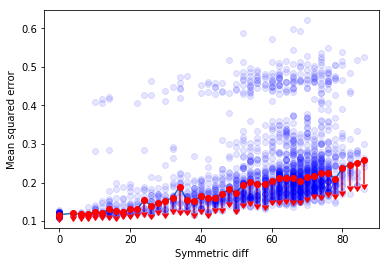

In [72]:
plt.plot(perm_top_data_frame.iloc[:,1],perm_top_data_frame.iloc[:,3],"bo", alpha=0.1)
plt.plot(medians.index.values,medians.iloc[:,2], "ro")
plt.errorbar(medians.index.values,medians.iloc[:,2],yerr=ms_error_y_err.values,lolims=False,uplims=True,ecolor="r", barsabove=True)
plt.xlabel("Symmetric diff") # <-- not divided by two here
plt.ylabel("Mean squared error")
plt.show()

A quick check of fit and eval experiments results - more details in a separate notebook

In [3]:
df = pd.read_csv("100k_fit_and_evaluate_experiments/fit_eval_results.csv",header=None)
df.sort_values([5])

,0,1,2,3,4,5
61,3,6,tanh,100k_fit_and_evaluate_experiments/model_3_6_ta...,0.015654,0.016347
26,4,6,tanh,100k_fit_and_evaluate_experiments/model_4_6_ta...,0.013958,0.016786
63,2,5,tanh,100k_fit_and_evaluate_experiments/model_2_5_ta...,0.016845,0.017154
27,6,6,tanh,100k_fit_and_evaluate_experiments/model_6_6_ta...,0.013177,0.017183
6,6,4,tanh,100k_fit_and_evaluate_experiments/model_6_4_ta...,0.015155,0.017238
54,5,3,tanh,100k_fit_and_evaluate_experiments/model_5_3_ta...,0.017120,0.017969
7,3,4,tanh,100k_fit_and_evaluate_experiments/model_3_4_ta...,0.016459,0.017978
36,5,5,tanh,100k_fit_and_evaluate_experiments/model_5_5_ta...,0.014324,0.018343
68,5,6,tanh,100k_fit_and_evaluate_experiments/model_5_6_ta...,0.013963,0.018536
59,6,3,tanh,100k_fit_and_evaluate_experiments/model_6_3_ta...,0.015926,0.018740


### Experiments with intermediate layers - visualization in mind, not included in the paper

Define a network and get its layer list:

In [6]:
nn_input = tf.placeholder(dtype=tf.float32, shape=[None, 21])
targets = tf.placeholder(dtype=tf.float32, shape=[None, 1])
nn_output, nn_layers = graph_nn.transfer_matrix_neural_net_with_layer_output(nn_input, 3, 4, tf.nn.tanh, ochota_adj_matrix, verbose=True, share_weights_in_transfer_matrix=False, share_biases_in_transfer_matrix=False)

(21, 48, 1, 4)
(?, 48, 4)
(48, 21, 4, 4)
(?, 21, 4)
(21, 48, 4, 4)
(?, 48, 4)
(?, 192)


In [7]:
nn_layers

[<tf.Tensor 'Placeholder:0' shape=(?, 21) dtype=float32>,
 <tf.Tensor 'Tanh:0' shape=(?, 48, 4) dtype=float32>,
 <tf.Tensor 'Tanh_1:0' shape=(?, 21, 4) dtype=float32>,
 <tf.Tensor 'Tanh_2:0' shape=(?, 48, 4) dtype=float32>,
 <tf.Tensor 'dense/Identity:0' shape=(?, 1) dtype=float32>]

Load a trained network:

In [8]:
# close session (if open)
try:
    sess.close()
except:
    pass

# open new session
sess =  tf.Session()

saver = tf.train.Saver()
saver.restore(sess, "100k_fit_and_evaluate_experiments/model_3_4_tanh.ckpt")

INFO:tensorflow:Restoring parameters from 100k_fit_and_evaluate_experiments/model_3_4_tanh.ckpt


In [19]:
model_avg_error, actual_vs_predicted = train_eval.evaluate_model_on_a_dataset("100k_fit_and_evaluate_experiments/model_3_4_tanh.ckpt", nn_output,nn_input, X_test, y_test, y_scaler)
print(model_avg_error)

INFO:tensorflow:Restoring parameters from 100k_fit_and_evaluate_experiments/model_3_4_tanh.ckpt
0.016459187597153417


Text(0.5,1,'Actual vs. predicted')

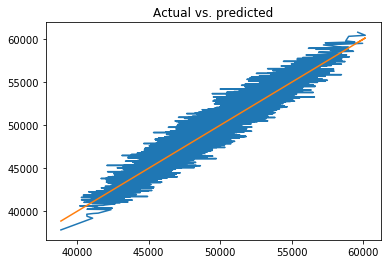

In [20]:
y_test_sorted = [x[0] for x in actual_vs_predicted]
y_test_pred_sorted = [x[1] for x in actual_vs_predicted]
plt.plot(y_test_pred_sorted, y_test_sorted)
plt.plot(y_test_pred_sorted, y_test_pred_sorted)
plt.title("Actual vs. predicted")

In [9]:
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)
example_X = X_test.iloc[y_test.idxmin(),:].values.reshape([1,-1])

Plot layer activations for the exemplary input:

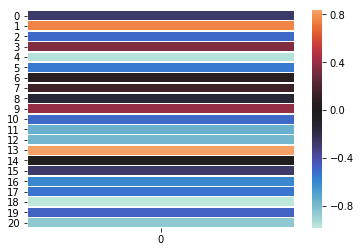

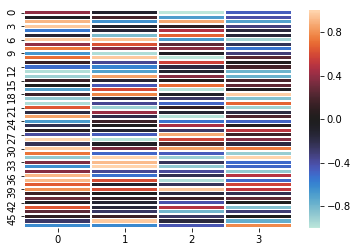

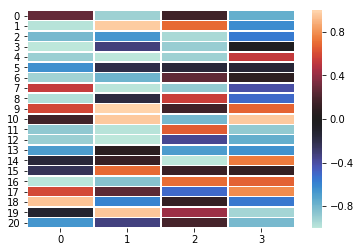

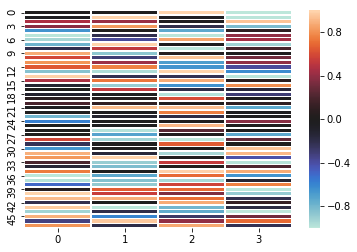

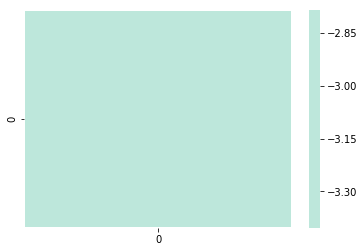

In [35]:
import seaborn as sns
for l in nn_layers:
    l_out = sess.run(l, feed_dict={nn_input: example_X})
    if len(l_out.shape) > 2:
        l_out_ = np.squeeze(l_out)
    else:
        l_out_ = np.transpose(l_out)
    sns.heatmap(l_out_, linewidth=0.5, center=0.0)
    plt.show()

Now for gradients:

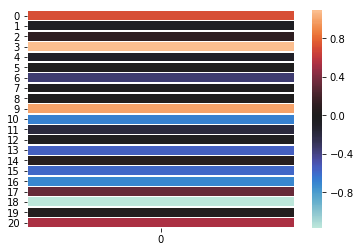

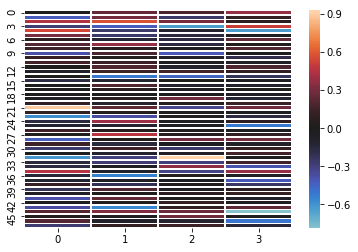

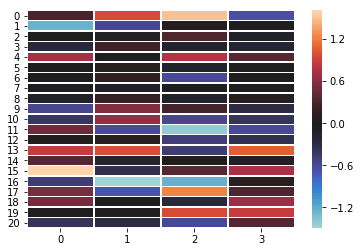

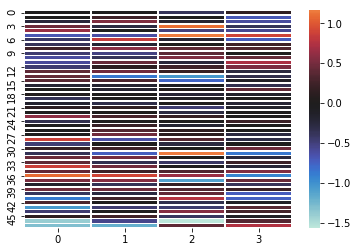

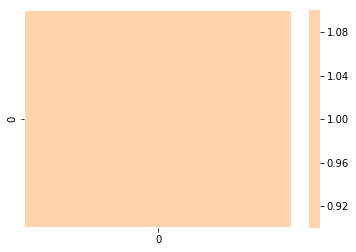

In [47]:
import seaborn as sns
for l in nn_layers:
    l_out = sess.run(l, feed_dict={nn_input: example_X})
    gradient_op = tf.gradients(nn_output, l)
    gradient = sess.run(gradient_op, feed_dict={nn_input: example_X})
    gradient = gradient[0].reshape(l_out.shape)
    if len(l_out.shape) > 2:
        l_out_ = np.squeeze(l_out)
        gradient_ = np.squeeze(gradient)
    else:
        l_out_ = np.transpose(l_out)
        gradient_ = np.transpose(gradient)
    sns.heatmap(gradient_, linewidth=0.5, center=0.0)
    plt.show()

The same thing for Kiepf's type network:

In [6]:
nn_input = tf.placeholder(dtype=tf.float32, shape=[None, 21])
targets = tf.placeholder(dtype=tf.float32, shape=[None, 1])
nn_output, nn_layers = graph_nn.kipfs_transfer_matrix_neural_net_with_layer_output(nn_input, 5, 4, tf.nn.tanh, ochota_adj_matrix, verbose=True)

(21, 21, 1, 4)
(?, 21, 4)
(21, 21, 4, 4)
(?, 21, 4)
(21, 21, 4, 4)
(?, 21, 4)
(21, 21, 4, 4)
(?, 21, 4)
(21, 21, 4, 4)
(?, 21, 4)
(?, 84)


In [7]:
optimizer = tf.train.AdamOptimizer(0.005)

In [7]:
nn_layers

[<tf.Tensor 'Placeholder:0' shape=(?, 21) dtype=float32>,
 <tf.Tensor 'Tanh:0' shape=(?, 21, 4) dtype=float32>,
 <tf.Tensor 'Tanh_1:0' shape=(?, 21, 4) dtype=float32>,
 <tf.Tensor 'Tanh_2:0' shape=(?, 21, 4) dtype=float32>,
 <tf.Tensor 'dense/Identity:0' shape=(?, 1) dtype=float32>]

In [7]:
# close session (if open)
try:
    sess.close()
except:
    pass

# open new session
sess =  tf.Session()

saver = tf.train.Saver()
saver.restore(sess, "trained_networks/kipfs_5_4_tanh_model.ckpt")

INFO:tensorflow:Restoring parameters from trained_networks/kipfs_5_4_tanh_model.ckpt


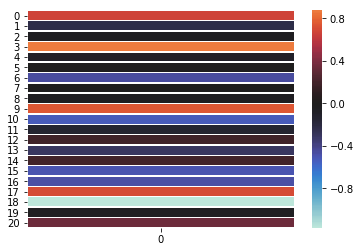

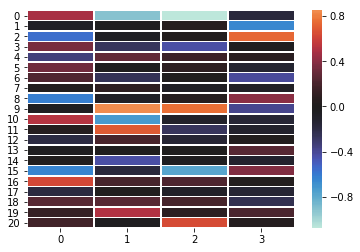

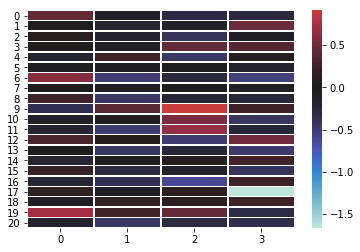

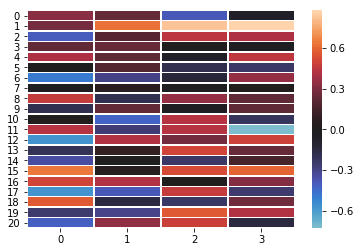

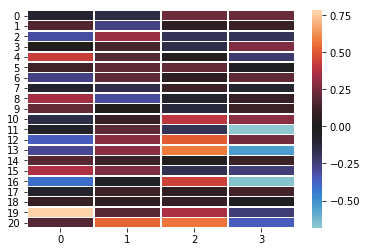

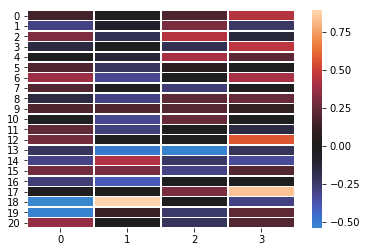

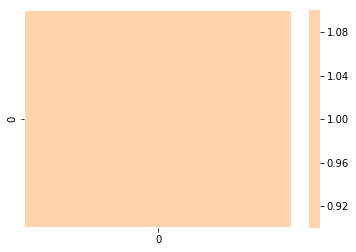

In [10]:
import seaborn as sns
for l in nn_layers:
    l_out = sess.run(l, feed_dict={nn_input: example_X})
    gradient_op = tf.gradients(nn_output, l)
    gradient = sess.run(gradient_op, feed_dict={nn_input: example_X})
    gradient = gradient[0].reshape(l_out.shape)
    if len(l_out.shape) > 2:
        l_out_ = np.squeeze(l_out)
        gradient_ = np.squeeze(gradient)
    else:
        l_out_ = np.transpose(l_out)
        gradient_ = np.transpose(gradient)
    sns.heatmap(gradient_, linewidth=0.5, center=0.0)
    plt.show()

In [30]:
updater = MomentumGradientDescent()

trajectory = train_eval.generate_gradient_descent_trajectory(sess, nn_output, nn_input, X_scaler, y_scaler, updater, 3000, 30, verbose=True)

Prediction 49839.535156, rounded: 49878.835938
Prediction 38128.316406, rounded: 38110.808594
Prediction 33890.445312, rounded: 33915.703125
Prediction 33365.394531, rounded: 33371.246094
Prediction 33266.769531, rounded: 33268.164062
Prediction 33220.554688, rounded: 33221.386719
Prediction 33197.457031, rounded: 33200.843750
Prediction 33183.570312, rounded: 33189.644531
Prediction 33173.433594, rounded: 33179.843750
Prediction 33165.074219, rounded: 33175.351562
Prediction 33157.796875, rounded: 33159.843750
Prediction 33151.292969, rounded: 33153.410156
Prediction 33145.414062, rounded: 33150.875000
Prediction 33140.066406, rounded: 33146.917969
Prediction 33135.191406, rounded: 33144.082031
Prediction 33130.734375, rounded: 33141.957031
Prediction 33126.667969, rounded: 33132.984375
Prediction 33122.937500, rounded: 33119.382812
Prediction 33119.519531, rounded: 33118.238281
Prediction 33116.363281, rounded: 33116.832031
Prediction 33113.457031, rounded: 33115.765625
Prediction 33

In [31]:
min_X_example = X_scaler.transform(np.array(trajectory[-1][0])).reshape(1,21)

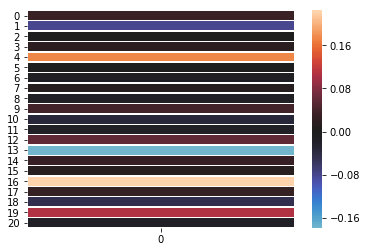

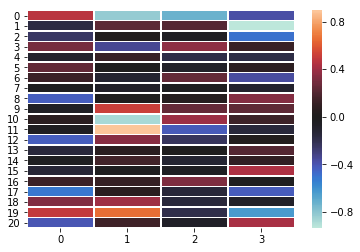

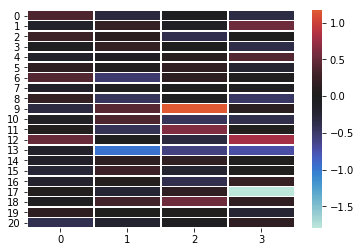

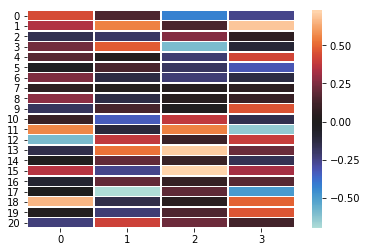

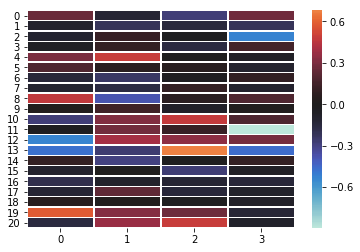

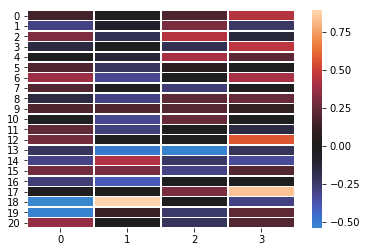

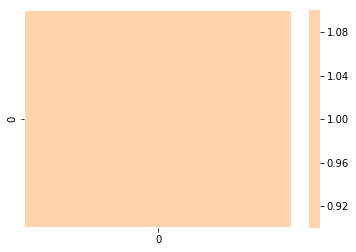

In [32]:
import seaborn as sns
for l in nn_layers:
    l_out = sess.run(l, feed_dict={nn_input: min_X_example})
    gradient_op = tf.gradients(nn_output, l)
    gradient = sess.run(gradient_op, feed_dict={nn_input: min_X_example})
    gradient = gradient[0].reshape(l_out.shape)
    if len(l_out.shape) > 2:
        l_out_ = np.squeeze(l_out)
        gradient_ = np.squeeze(gradient)
    else:
        l_out_ = np.transpose(l_out)
        gradient_ = np.transpose(gradient)
    sns.heatmap(gradient_, linewidth=0.5, center=0.0)
    plt.show()